<h1><center>MASKTUNE: Mitigating Spurious Correlations by forcing to explore</center></h1>

## CELEBA<br>
In this notebook we focus our attenction in a different dataset: CELEBA.

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations.

In the CelebA dataset,
there is a high correlation between features gender={male, female} and hair_color={blond, dark},
meaning that the feature gender might be used as predictor to the hair_color.

In other words, the model would assign the label dark to male images since the majority of male images have dark
hair, and there are only 1,387 (0.85%) blond males in the training set of size 162,770.

The goal of MaskTune in this dataset is to force the model to explore new features of the input images in order to eliminate the spurious correlation male $\rightarrow$ dark hair color.
 

### 1.1 Download Dataset
CelebA dataset is imported by Kaggle. It is important that who want to run this notebook has the kaggle api file called kaggle.json

This file could be downloaded from your profile on kaggle and it must be imported on this notebook using the dedicated cell.

In [ ]:
!pip install timm
!pip install grad-cam

In [2]:
#only in google colab
!git clone https://github.com/Giordano-Cicchetti/MaskTune_NN/
!cp MaskTune_NN/CelebA/* /content -r
!rm MaskTune_NN/ -r

Cloning into 'MaskTune_NN'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 349 (delta 78), reused 94 (delta 41), pack-reused 204
Receiving objects: 100% (349/349), 31.84 MiB | 35.32 MiB/s, done.
Resolving deltas: 100% (172/172), done.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d jessicali9530/celeba-dataset --force
!chmod 600 /content/kaggle.json
!mkdir data
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall("data")

 98% 1.30G/1.33G [00:06<00:00, 250MB/s]
100% 1.33G/1.33G [00:06<00:00, 211MB/s]


### 1.2 Download Trained Models

If you want, you can use this cell to retrieve trained models saved on google drive.

We cannot store trained models on github because the dimensions were too big.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1PBgRKydqX1t1WOG-bvlcIgETJsVkoJnm
!gdown --id 1X48tiyZC4ELGN6kLS3Vz0r2WCZTEuHX2
!gdown --id 1zFEBHHyyjlVtol19N2CgX08KHkeaO585

### 2. TRAIN MODEL


In [6]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

The creation of the Train/Validation/Test datasets and corrispondent data loaders is done in the constructor of the class Train_CelebA. The code can be explored in the files of our GitHub repository <a href="https://github.com/Giordano-Cicchetti/MaskTune_NN/blob/main/CelebA/TrainCelebA.py">CelebA/TrainCelebA.py</a> and <a href="https://github.com/Giordano-Cicchetti/MaskTune_NN/blob/main/CelebA/TrainCelebA.py">CelebA/CelebA.py</a>

In [7]:
from TrainCelebA import *
Train_CelebA=CelebATrain(device=device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(




start creating and saving train dataset of CelebA


---------- indexing train data ----------


100%|██████████| 202599/202599 [00:21<00:00, 9539.84it/s] 




finished creating and saving train dataset of CelebA




start creating and saving valid dataset of CelebA


---------- indexing valid data ----------


100%|██████████| 202599/202599 [00:02<00:00, 77814.57it/s]  




finished creating and saving valid dataset of CelebA




start creating and saving test dataset of CelebA


---------- indexing test data ----------


100%|██████████| 202599/202599 [00:02<00:00, 77651.29it/s]  



finished creating and saving test dataset of CelebA




We are ready to train a model that will accomplish the task of classify the color of the hair of the subjects inside images.
>The model used is a Pre-trained ResNet50.
We put the code of the model inside this notebook only for completeness.
<br>It is the same architecture used by the authors of the paper. Our goal is to achieve the same results using the same architecture.


Parameters:


*   learning rate ⇒ 1e-4
*   momentum ⇒ 0.9
*   weight decay ⇒ 0.0001
*   batch size ⇒ 128  

In [ ]:
import torch.nn as nn
import timm
#`timm` is a deep-learning library and a collection of SOTA computer vision models,
# layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating 
# scripts with ability to reproduce ImageNet training results.

#From Timm we import a pretrained resnet50. Pretrained on ImageNet
class ResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=pretrained, num_classes=num_classes)
        
    def get_grad_cam_target_layer(self):
        return self.model.layer4[-1]

    def forward(self, x):
        return self.model(x)

This model has been fine tuned for 20 epoch over the CelebA train dataset.

In [ ]:
Train_CelebA.train_erm(epochs=20)

train epoch 7:  76%|███████▌  | 966/1272 [21:01<06:40,  1.31s/it, loss=0.201, accuracy=0.923]

<h1><center>................................. </center></h1>

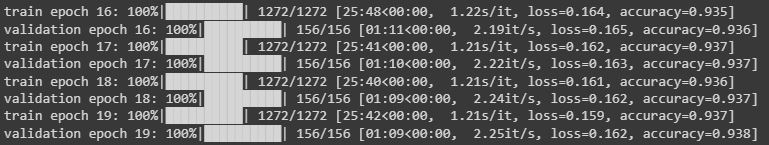

After the training phase we can evaluate the model over the test dataset.
We calculate the accuracy of the model in this four possible scenarios:
>Group 1: non-male with non-blonde hair; Accuracy 95.9%

>Group 2: non-male with blonde hair; Accuracy 75.9%

>Group 3: male with non-blonde hair; Accuracy 99.6%

>Group 4: male with blonde hair; Accuracy 22.2%

As we can see the accuracy on the fourth group is very low; This beacuse the model associate with high probability male to non-blonde hair.


In [8]:
Train_CelebA.test(Train_CelebA.test_loader,"best_erm_model.pt")

----------testing the model----------


Test epoch 19: 100%|██████████| 156/156 [01:16<00:00,  2.03it/s, loss=0.147]


accuracy of group 1: 0.9593529231084263
accuracy of group 2: 0.7596774193548387
accuracy of group 3: 0.9961512939615129
accuracy of group 4: 0.2222222222222222
average accuracy: 0.9417893998597335
----------Test accuracy =0.2222222222222222----------


Now we apply the finetune function.<br>
The training data are masked using the best trained model and then the last model is finetuned with a single epoch using the masked dataset.

In [ ]:
def finetune(best_resume_checkpoint_path: str=None, last_resume_checkpoint_path: str=None) -> None:
  
  if(best_resume_checkpoint_path!=None and last_resume_checkpoint_path!=None):
    #Mask the data
    Train_CelebA.mask_data(Train_CelebA.train_loader,best_resume_checkpoint_path)
    #Load the model
    checkpoint = torch.load(last_resume_checkpoint_path)
    Train_CelebA.model.load_state_dict(checkpoint['model_state_dict'])
    Train_CelebA.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    resume_epoch = checkpoint['epoch'] + 1

    #Run a training epoch using the masked dataset
    Train_CelebA.run_an_epoch(data_loader=Train_CelebA.masked_loader,epoch=resume_epoch,mode="train",device=Train_CelebA.device)
    val_accuracy = Train_CelebA.run_an_epoch(
        data_loader=Train_CelebA.val_loader, epoch=resume_epoch, mode="validation",device=Train_CelebA.device
    )
    #Save the finetuned model
    torch.save({
                'epoch': resume_epoch,
                'model_state_dict': Train_CelebA.model.state_dict(),
                'optimizer_state_dict': Train_CelebA.optimizer.state_dict(),
                'accuracy' : val_accuracy,
                }, "masked_erm_model.pt")
    

finetune(best_resume_checkpoint_path="best_erm_model.pt",last_resume_checkpoint_path="last_erm_model.pt")

100%|██████████| 1272/1272 [24:32<00:00,  1.16s/it]


---------- indexing Masked data ----------


validation epoch 20: 100%|██████████| 156/156 [01:11<00:00,  2.18it/s, loss=0.173, accuracy=0.932]


Final tests show that this methodology is able to increase the accuracy on the worst group/groups.
We can take as example <b>group 2</b> where the accuracy goes from 75% to 83%
And <b>group 4</b> where the accuracy goes from 22.2% to 27.2%

Unfortunately,even if we notice improvements with the finetune function, in this dataset we are not able to match the accuracy mentioned in the paper: 78.0% on the worst group.


In [15]:
Train_CelebA.test(Train_CelebA.test_loader,"masked_erm_model.pt")

----------testing the model----------


Test epoch 20: 100%|██████████| 156/156 [01:10<00:00,  2.22it/s, loss=0.154]

accuracy of group 1: 0.9380567216135968
accuracy of group 2: 0.8379032258064516
accuracy of group 3: 0.9930988719309887
accuracy of group 4: 0.2722222222222222
average accuracy: 0.9403867347961126
----------Test accuracy =0.2722222222222222----------


Text(0.5, 1.0, 'HeatMap after mask application')

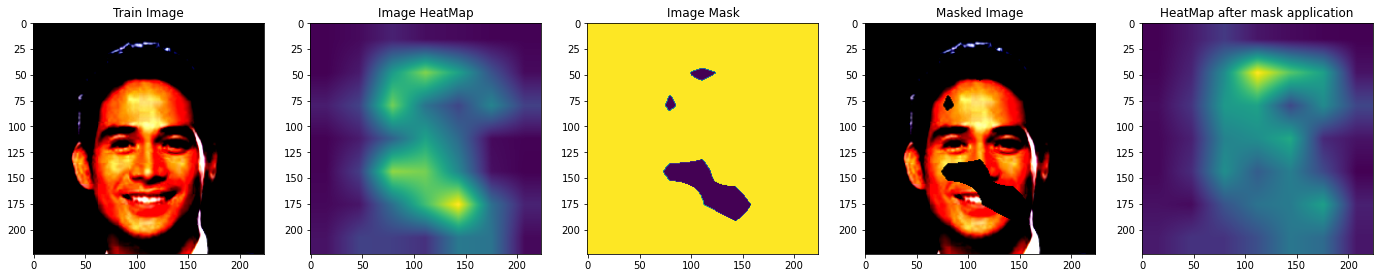

In [ ]:
import numpy as np
from pytorch_grad_cam import XGradCAM
import matplotlib.pyplot as plt


checkpoint = torch.load("best_erm_model.pt")
Train_CelebA.model.load_state_dict(checkpoint['model_state_dict'])
heat_map_generator = XGradCAM(
        model= Train_CelebA.model,
        target_layers=[Train_CelebA.model.get_grad_cam_target_layer()],
        use_cuda=True,
    )
fig, axs = plt.subplots(1, 5,figsize=(24, 10))
image=Train_CelebA.train_dataset[11][0]
axs[0].imshow(image.permute(1,2,0))
axs[0].set_title("Train Image")
image= torch.unsqueeze(image,0)
image= image.to(device)
hm = heat_map_generator(image)
axs[1].imshow(hm[0])
axs[1].set_title("Image HeatMap")
mask_mean_value = np.nanmean(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
mask_std_value = np.nanstd(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
mask_threshold_value = mask_mean_value + 2 * mask_std_value
mask = np.where(hm > mask_threshold_value, 0, 1)
axs[2].imshow(mask[0])
axs[2].set_title("Image Mask")
masked_img=(image[0].cpu()*mask)
axs[3].imshow(masked_img.permute(1,2,0))
axs[3].set_title("Masked Image")
checkpoint = torch.load("masked_erm_model.pt")
Train_CelebA.model.load_state_dict(checkpoint['model_state_dict'])
heat_map_generator = XGradCAM(
        model= Train_CelebA.model,
        target_layers=[Train_CelebA.model.get_grad_cam_target_layer()],
        use_cuda=True,
    )
masked_image= torch.unsqueeze(masked_img,0)
masked_image= masked_image.to(device)
masked_image_hm = heat_map_generator(masked_image.float())
axs[4].imshow(masked_image_hm[0])
axs[4].set_title("HeatMap after mask application")